In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import Image

from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder




In [58]:
class ImageFolder(Dataset):

    model_a = {'stylegan2'}
    model_b = {'gau_gan'}

    def __init__(self, root_dir, model_a, model_b, metadata_name='metadata.csv', nrows=None, transform=None, random_state=42):
        self.root_dir = Path(root_dir)
        self.metadata_name = metadata_name
        self.transform = transform
        self.random_state = random_state

        # Carica immagini per ciascun modello
        samples_a = self._load_samples(model_a, label=model_a, nrows=nrows)
        samples_b = self._load_samples(model_b, label=model_b, nrows=nrows)

        print(f"✅ Caricate immagini: '{model_a}': {len(samples_a)} — '{model_b}': {len(samples_b)}")

        # Combina e bilancia
        all_samples = samples_a + samples_b
        if len(samples_a) == 0 or len(samples_b) == 0:
            raise ValueError(f"‼️ Dataset non valido: una delle due classi ha 0 immagini. '{model_a}': {len(samples_a)} - '{model_b}': {len(samples_b)}")
        self.samples = self._balance_binary(all_samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        full_path = self.root_dir / img_path
        image = Image.open(full_path).convert('RGB')
        return (self.transform(image) if self.transform else image), label
        


    def _load_samples(self, folder, label, nrows=None):
        samples = []
        folder_path = self.root_dir / folder
        meta_file = folder_path / self.metadata_name

        if not meta_file.exists():
            print(f"⚠️ Metadata file not found for folder: {folder}")
            return samples

        df = pd.read_csv(meta_file)  # con header!
        required_cols = {'image_path', 'target'}
        if not required_cols.issubset(df.columns):
            print(f"⚠️ Metadata missing required columns in: {meta_file}")
            return samples

        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        num_nan = df['target'].isna().sum()
        if num_nan > 0:
            print(f"⚠️ '{folder}': trovati {num_nan} valori NaN in 'target'")

        print(f"[DEBUG] '{folder}' - target unique values: {df['target'].dropna().unique()}")
        df = df[df['target'] > 0]

        if nrows:
            df = df.head(nrows)

        for rel_path in df['image_path']:
            rel_to_root = Path(folder) / rel_path
            samples.append((rel_to_root, label))

        return samples

    def _balance_binary(self, samples):
        X = [[str(p)] for p, _ in samples]
        y = [label for _, label in samples]

        rus = RandomUnderSampler(random_state=self.random_state)
        X_res, y_res = rus.fit_resample(X, y)

        return [(Path(x[0]), y) for x, y in zip(X_res, y_res)]


In [59]:
def train_SVM(dataset: pd.DataFrame, test_size=0.4):
    # Estrai X e label testuali
    X = dataset.drop(columns='label').values
    y_str = dataset['label'].values

    # Codifica le label in modo anonimo (es. 0, 1) ma in modo non controllato
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)  # y sarà numerico, es. [0, 1, 0, 1...]

    # Stratified split (preserva la distribuzione)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # SVM con bilanciamento
    svc = SVC(class_weight='balanced')
    param_grid = [
        {'kernel': ['linear'],  'C': [0.1, 1, 10]},
        {'kernel': ['rbf'],     'C': [1, 10], 'gamma': ['scale', 0.1]},
        {'kernel': ['sigmoid'], 'C': [1, 10], 'gamma': ['scale', 0.1], 'coef0': [0.0, 0.1, 0.5]}
    ]

    grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    # Predizione
    prediction = grid.predict(X_test)

    # Decodifica per report leggibile
    y_test_labels = label_encoder.inverse_transform(y_test)
    pred_labels = label_encoder.inverse_transform(prediction)

    # Report
    print(f"Best params: {grid.best_params_}")
    accuracy = accuracy_score(y_test_labels, pred_labels)
    print(f'The accuracy of the SVM is: {accuracy}')
    print(f'Classification Report:\n{classification_report(y_test_labels, pred_labels)}')
    cf = confusion_matrix(y_test_labels, pred_labels)
    print(f'Confusion Matrix:\n{cf}')
    plot_confusion_matrix(cf, label_encoder.classes_)


def plot_confusion_matrix(cf, class_labels):
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cf.shape)

    ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Confusion Matrix\n')
    ax.set_xlabel('\nClasse immagine predetta')
    ax.set_ylabel('Classe reale immagine')
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    plt.tight_layout()
    plt.show()

[DEBUG] 'stylegan2' - target unique values: [1]
[DEBUG] 'gau_gan' - target unique values: [6]
✅ Caricate immagini: 'stylegan2': 10 — 'gau_gan': 10


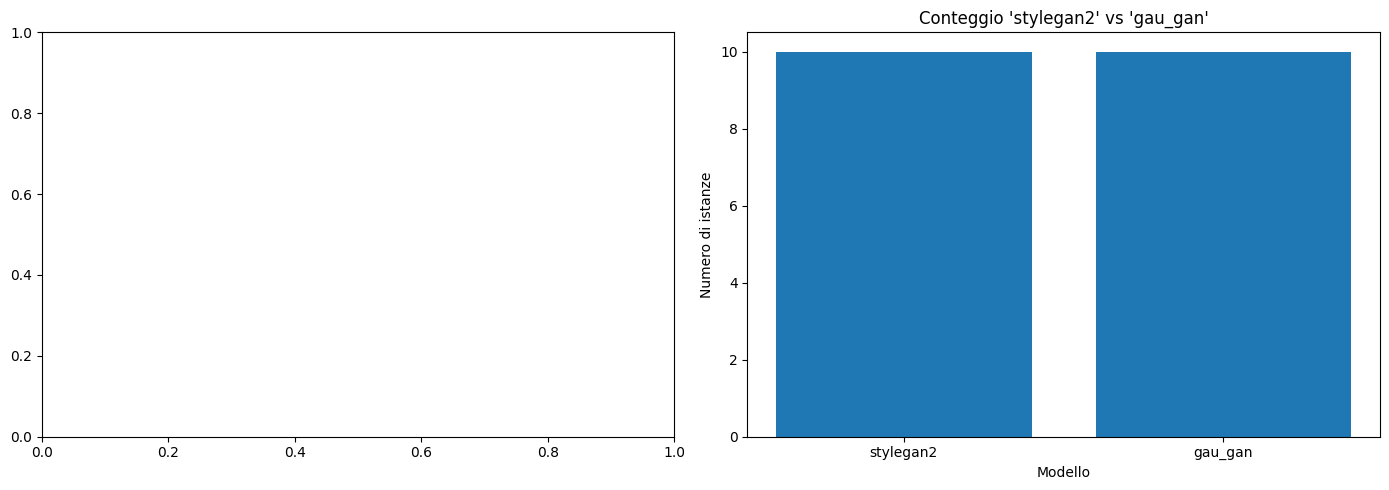

In [61]:
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

dataset = ImageFolder(root_dir='./archive', model_a="stylegan2", model_b="gau_gan", nrows=10, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
data = pd.DataFrame(dataset.samples, columns=['path', 'label'])


# --- Primo istogramma: conteggio di ogni label diversa da 'real' ---
#df_excl = data[data['label'] != 'real']
#counts_excl = df_excl['label'].value_counts().sort_index()  # sort_index per ordine alfabetico

# --- Secondo istogramma: binarizzazione model_a vs model_b ---
binary = data['label'].apply(lambda x: 'stylegan2' if x == 'stylegan2' else 'gau_gan')
counts_bin = binary.value_counts().loc[['stylegan2','gau_gan']]  # garantisce l'ordine


# --- Disegna i due plot affiancati ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot delle label (escluse 'real')
#axes[0].bar(counts_excl.index, counts_excl.values)
#axes[0].set_title("Conteggio per ogni generatore (escluse 'real')")
#axes[0].set_xlabel("Generatori")
#axes[0].set_ylabel("Numero di istanze")
#axes[0].tick_params(axis='x', rotation=90)

# Bar plot binario real vs fake
axes[1].bar(counts_bin.index, counts_bin.values)
axes[1].set_title("Conteggio 'stylegan2' vs 'gau_gan'")
axes[1].set_xlabel("Modello")
axes[1].set_ylabel("Numero di istanze")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# carica ViT-B/16 pretrained da torchvision
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# rimuove la testa di classificazione
model.heads.head = nn.Identity()
model.eval().to(device)

all_feats = []
all_labels = []
all_paths = []

with torch.no_grad():
    for imgs, labs in loader:
        imgs = imgs.to(device)
        feats = model(imgs)
        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labs)

# prepara DataFrame
features = np.vstack(all_feats)
labels = np.array(all_labels)

feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = labels
df['label'] = df['label'].apply(lambda x: 'stylegan2' if x == 'stylegan2' else 'gau_gan')

df.groupby('label').size()

label
gau_gan      10
stylegan2    10
dtype: int64

In [63]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,label
0,1.056757,0.949450,0.313502,0.353384,-0.166555,0.161424,-0.101406,-0.139735,-0.919813,0.379433,...,-0.250385,-0.536249,-0.295882,-0.154051,-0.540916,-0.005937,2.082788,-0.834113,-0.373973,gau_gan
1,-0.245423,-0.087800,0.436198,0.008099,-0.631596,0.135404,0.690159,-0.692070,-1.035792,0.758250,...,-0.404882,-0.052208,0.470937,0.438565,0.466208,-0.194170,0.642651,-0.591036,-0.044195,gau_gan
2,0.457248,1.076163,-0.378291,0.788185,0.095294,-1.514342,-0.119835,0.185643,0.056339,0.804034,...,-0.385359,-0.903524,-0.385557,0.180061,-0.577650,-0.106292,1.309827,1.360834,2.331254,gau_gan
3,-0.399047,1.124076,0.596095,-0.212143,-0.229065,2.253670,-0.050871,0.438523,0.154703,0.321464,...,-0.270454,-0.390901,0.572076,-0.384285,-1.010841,-0.223151,-0.119426,-0.408593,-0.049456,gau_gan
4,-0.310922,1.483954,1.249722,-0.642216,0.245314,-1.341013,-0.744035,-0.464610,-1.045288,-0.306227,...,-0.198137,0.065792,-0.139791,-0.641702,-0.461125,-0.719621,1.478515,0.705871,-1.217507,gau_gan


In [64]:
train_SVM(df)

NameError: name 'LabelEncoder' is not defined

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.8293333333333334
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.82      1463
        real       0.83      0.84      0.83      1537

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

Confusion Matrix:
 [[1203  260]
 [ 252 1285]]


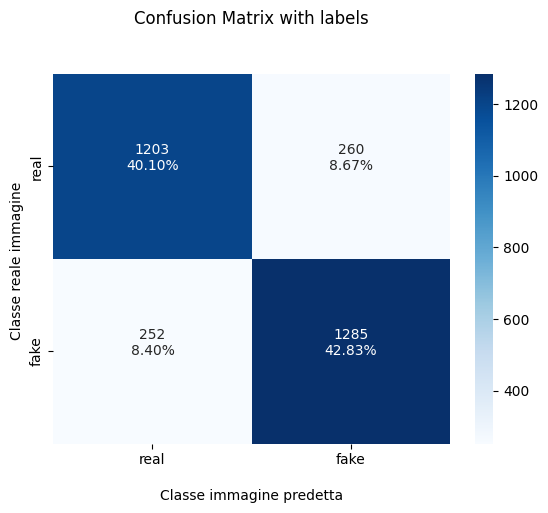

In [203]:
train_SVM(df, test_size=0.3)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.84
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.84      0.84       988
        real       0.85      0.84      0.84      1012

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Confusion Matrix:
 [[834 154]
 [166 846]]


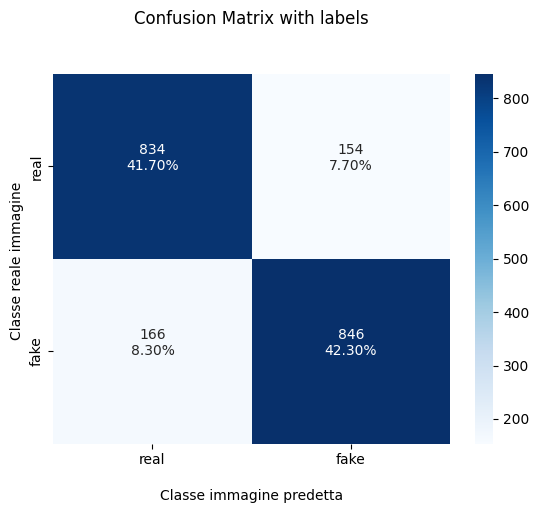

In [202]:
train_SVM(df, test_size=0.2)

# Riduzione del numero delle features

In [198]:
feat_cols = [c for c in df.columns if c.startswith('feat_')]
X = df[feat_cols].values

pca_full = PCA().fit(X)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumvar >= 0.95) + 1
print(f"Numero di componenti per 95% varianza: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)

label_col = 'label'
df_labels = df[[label_col]]

df_reduced = pd.concat([df_labels, df_pca], axis=1)

print("Shape originale:", df.shape)
print("Shape ridotto:", df_reduced.shape)
df_reduced.head()

Numero di componenti per 95% varianza: 539
Shape originale: (10000, 769)
Shape ridotto: (10000, 540)


,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC530,PC531,PC532,PC533,PC534,PC535,PC536,PC537,PC538,PC539
0,real,4.452354,3.978933,-5.100599,-2.845080,2.393063,-3.378103,-0.478175,-1.164739,0.506738,...,0.221882,-0.021428,0.238291,0.069487,0.048895,-0.128180,-0.150365,0.160290,-0.001368,0.142459
1,real,3.355122,1.340310,7.552821,-2.955248,-0.087137,-1.808826,-1.844605,-0.072198,0.739899,...,0.023672,-0.487108,0.750218,0.116960,-0.112095,0.171651,0.461197,-0.026801,0.350918,0.283016
2,real,2.668023,-1.267077,-0.466516,5.855372,-3.587316,-5.536855,-1.771551,1.483594,-0.750182,...,-0.253152,0.032078,0.265634,0.094457,-0.148960,0.070609,-0.024995,-0.302863,0.341082,-0.154679
3,real,1.095603,-2.496210,0.118950,8.119945,-3.602722,-6.295508,-2.707063,2.054513,-2.793349,...,-0.472182,-0.000510,0.272494,-0.066684,0.334183,-0.409192,0.287666,0.386480,0.632607,-0.387555
4,real,1.975390,-1.842172,-0.066451,8.059998,-3.586017,-6.746128,-2.492060,1.878367,-1.626043,...,0.267808,0.523695,-0.086625,-0.460583,-0.345682,-0.111448,0.083296,0.441894,0.089414,-0.163826


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.82
Classification Report:
              precision    recall  f1-score   support

        fake       0.81      0.82      0.82      1942
        real       0.83      0.82      0.82      2058

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000

Confusion Matrix:
 [[1599  343]
 [ 377 1681]]


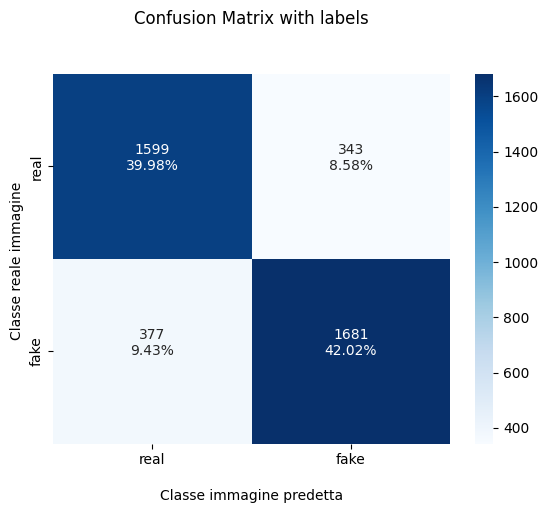

In [199]:
train_SVM(df_reduced)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.8276666666666667
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.82      1463
        real       0.83      0.84      0.83      1537

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

Confusion Matrix:
 [[1199  264]
 [ 253 1284]]


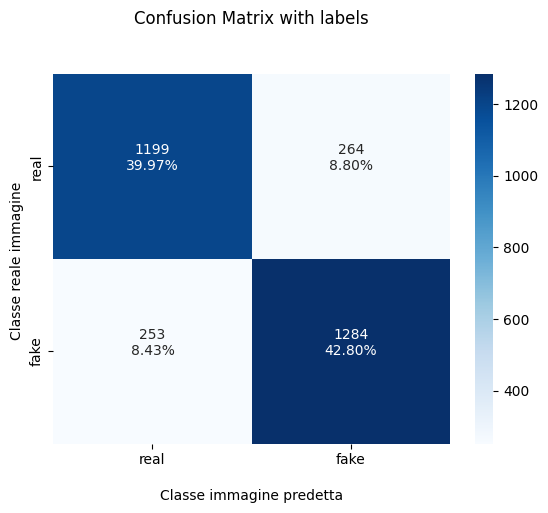

In [204]:
train_SVM(df_reduced, test_size=0.3)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.831
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.83       988
        real       0.83      0.84      0.83      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Confusion Matrix:
 [[815 173]
 [165 847]]


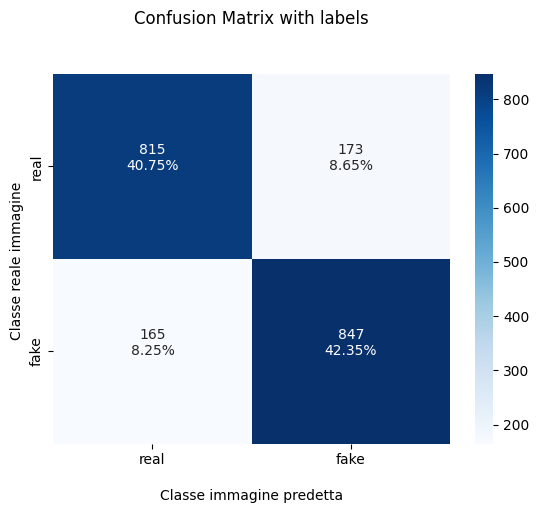

In [201]:
train_SVM(df_reduced, test_size=0.2)